In [1]:
##libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt

In [58]:
##read data - biomass, Virginia LTER
df = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_ChristianBlum.csv', skiprows=21)
df = df[df['speciesName'] == 'Spartina alterniflora'] ##only low marsh and creekbank???
df = df[['EOYBYear', 'collectDate', 'marshName', 'siteName', 'locationID', 'monitoringPurpose', \
         'Transect', 'Replicate', 'speciesName', 'liveMass', 'deadMass', 'totalMass', 'latitude', 'longitude']]
df['collectDate'] = pd.to_datetime(df['collectDate'])
df['liveMass'] = 16 * df['liveMass'] ##look at histograms; is averaging the best way?
df['deadMass'] = 16 * df['deadMass']
df['totalMass'] = 16 * df['totalMass']
locations = [1, 2] ## 1 = creekbank; 2 = low marsh
#df = df[df['locationID'].isin(locations)] ##MOSTLY Spartina alterniflora-only plots; in other zones plots were mixed

##water quality dataset, Virginia LTER
df_wq = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_WQ.csv', skiprows=21)
df_wq['measureDate'] = pd.to_datetime(df_wq['measureDate'])

max(df['liveMass'])

#df
##IMPORTANT NOTE: 2017 data does not distinguish live from dead biomass due to a freezer failure

3103.36

In [59]:
##summary statistics
df_means = df.groupby('EOYBYear', as_index = False).mean()
df_sem = df.groupby('EOYBYear').sem()

df_means['Year'] = df_means['EOYBYear']
#df.groupby('EOYBYear').aggregate([np.mean, np.size])
#df_means ##'average lat/long' useless
#df_sem

In [60]:
##grouped by site and by year
mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size]).reset_index()
se_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).sem()

newdf = df.groupby(['siteName', 'EOYBYear'], as_index = False).mean()

##rearrange lat and long for GEE
mn_siteyears = mn_siteyears[['siteName', 'EOYBYear', 'locationID', 'liveMass', 'longitude', \
                             'latitude', 'deadMass', 'totalMass']]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    #print(mn_siteyears)

#print(se_siteyears)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'outx2.csv')
#se_siteyears.to_csv(out_csv, index=False) ##set out directory

newdf['year'] = newdf['EOYBYear']

In [61]:
##some figures
#df.boxplot(column='liveMass', by='EOYBYear')
#mn_siteyears.boxplot(column='liveMass', by='siteName') ##using averages as individual points

In [62]:
##data analysis with cloud-masked data
#masked_ndvi = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/masked_ndvi.csv')
l5l7l8 = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/L5L7L8_combined.csv')
masked_ndvi = pd.merge(newdf, l5l7l8, on=['year', 'siteName'])   
    
masked_ndvi['EOYBYear'] = pd.to_datetime(masked_ndvi['EOYBYear'], format = '%Y')
masked_ndvi['imagedate'] = pd.to_datetime(masked_ndvi['imagedate'], format = '%m/%d/%y')
masked_ndvi['year'] = pd.DatetimeIndex(pd.to_datetime(round(masked_ndvi['year']), format = '%Y')).year

masked_ndvi['sqrtLive'] = np.sqrt(masked_ndvi['liveMass']) ##in case 'liveMass' does not meet assumptions
xxyrs = [2001, 2003, 2004, 2005, 2006, 2007, 2012, 2013, 2014, 2015, 2016]
masked_ndvi = masked_ndvi[masked_ndvi['year'].isin(xxyrs)] ##filtering out years where high tide -> flooded pixels

masked_ndvi = masked_ndvi[masked_ndvi['ndvi'] > 0] ##Gets rid of obviously flooded pixels and NA values

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    print(masked_ndvi)

         siteName   EOYBYear  locationID    liveMass    deadMass    totalMass  \
1      Assateague 2001-01-01    1.500000  406.653333  103.080000   509.733333   
4        Box_Tree 2001-01-01    1.500000  953.700000  202.360000  1156.060000   
6        Box_Tree 2004-01-01    2.000000  485.484444  170.782222   656.266667   
7        Box_Tree 2007-01-01    1.875000  374.050000  101.310000   475.360000   
10       Box_Tree 2012-01-01    1.461538  510.449231   98.855385   609.304615   
11       Box_Tree 2013-01-01    1.714286  396.971429    0.000000   396.971429   
12       Box_Tree 2016-01-01    1.692308  406.941538    0.000000   406.941538   
14  Channel_Point 2001-01-01    1.875000  729.570000  391.030000  1120.600000   
15       Cushmans 2001-01-01    2.058824  376.414118  230.757647   607.171765   
17       Cushmans 2005-01-01    2.200000  564.192000  144.312000   708.504000   
18       Cushmans 2007-01-01    1.875000  513.360000  388.230000   901.590000   
21       Cushmans 2012-01-01

In [63]:
##Training and testing biomass ~ ndvi: getting datasets
#train, test = train_test_split(masked_ndvi, test_size = 0.3) ##have to redo next chunk every time you run this


Intercept     219.365990
VDVI         2617.508017
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               liveMass   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     15.23
Date:                Wed, 05 May 2021   Prob (F-statistic):           0.000413
Time:                        13:52:02   Log-Likelihood:                -236.73
No. Observations:                  37   AIC:                             477.5
Df Residuals:                      35   BIC:                             480.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

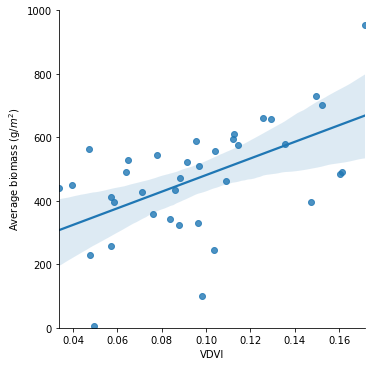

In [122]:
##Training and testing biomass ~ ndvi
result = sm.ols(formula="liveMass ~ VDVI", data = train).fit() #mass = 2617.4 * vdvi + 219.4
print(result.params)
print(result.summary())

g = sns.lmplot(x = "VDVI", y = "liveMass", ci = 95, data=train) ##CI seems a little too small?
g.set_axis_labels("VDVI", "Average biomass (g/$m^2$)")
g.set(ylim=(0, None))

<ipython-input-80-07167c5835a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = 2617.5 * test['VDVI'] + 219.4


204.42076731940168

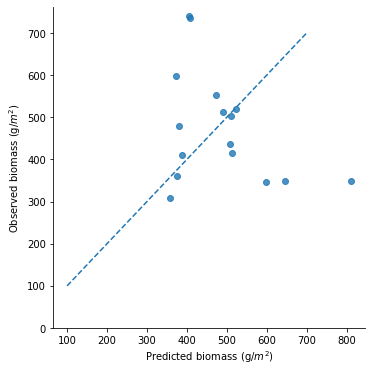

In [80]:
##plot observed vs predicted
test['predicted'] = 2617.5 * test['VDVI'] + 219.4
x = sns.lmplot(x = "liveMass", y = "predicted", fit_reg=False, data=test)
x.set_axis_labels("Predicted biomass (g/$m^2$)", "Observed biomass (g/$m^2$)")
x.set(ylim=(0, None))

plt.plot([100, 700], [100, 700], '--')

##RMSE
actual = test['liveMass']
predicted = test['predicted']

mse = sklearn.metrics.mean_squared_error(actual, predicted)
sqrt(mse)

0.2769120743079044

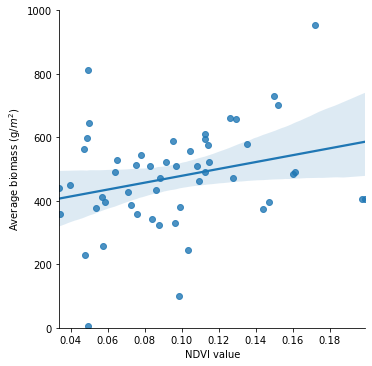

In [118]:
##Plots - all data together (no train/test)
g = sns.lmplot(x = "VDVI", y = "liveMass", ci = 95, data=masked_ndvi) ##CI seems a little too small?
g.set_axis_labels("NDVI value", "Average biomass (g/$m^2$)")
g.set(ylim=(0, None))

masked_ndvi['VDVI'].corr(masked_ndvi['liveMass'], method = 'pearson')

#my_path = os.path.abspath('/Users/asariversjulien/Documents/Georgia/Project')
#my_file = 'p1.png'
#g.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')

##FLOODED PLOTS. something to consider with image collection that you have
##Error bars???

In [35]:
result = sm.ols(formula="liveMass ~ VDVI", data = masked_ndvi).fit()
print(result.params)
print(result.summary())

Intercept     370.539827
VDVI         1082.992397
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               liveMass   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     4.235
Date:                Tue, 04 May 2021   Prob (F-statistic):             0.0447
Time:                        13:04:47   Log-Likelihood:                -341.86
No. Observations:                  53   AIC:                             687.7
Df Residuals:                      51   BIC:                             691.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

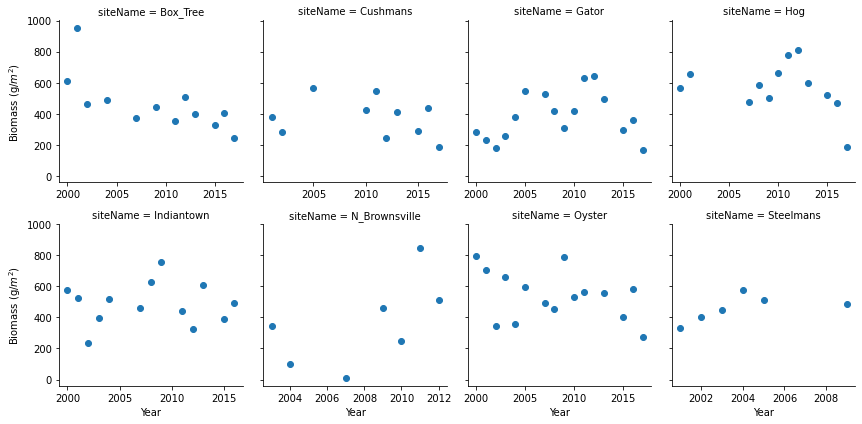

In [14]:
site_list = ['Box_Tree', 'Cushmans', 'Gator', 'Hog', 'Indiantown', 'N_Brownsville', 'Oyster', 'Steelmans']
df2 = masked_ndvi[masked_ndvi['siteName'].isin(site_list)]
g = sns.FacetGrid(df2, col="siteName", col_wrap=4,  sharex=False)
#g = sns.FacetGrid(masked_ndvi[masked_ndvi['siteName'] == 'Box_Tree'], col="siteName",  sharex=False)
g = g.map(plt.scatter, 'year', 'liveMass') ##interesting patterns here!!
g.set_axis_labels("Year", "Biomass (g/$m^2$)")
##Boxtree/Cushmans/Hog/Oyster = steady decrease in biomass over time
##Gator cyclical. Steelmans the only site that increased, but low N


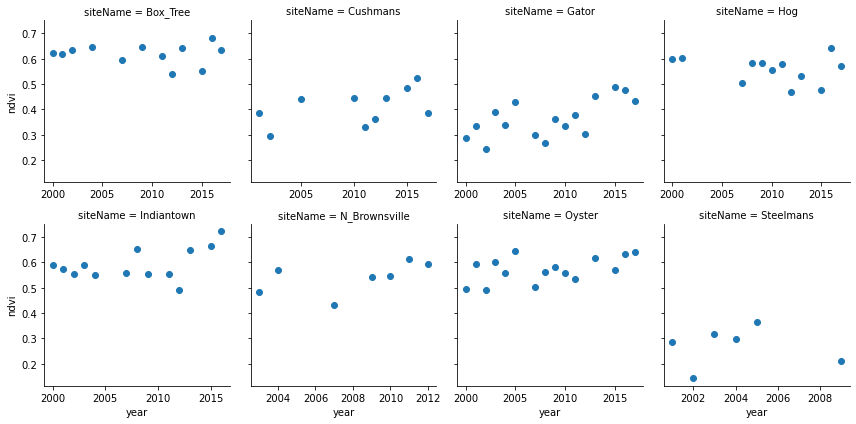

In [69]:
x_x = sns.FacetGrid(df2, col="siteName", col_wrap=4,  sharex=False)
g_x = x_x.map(plt.scatter, 'year', 'ndvi')

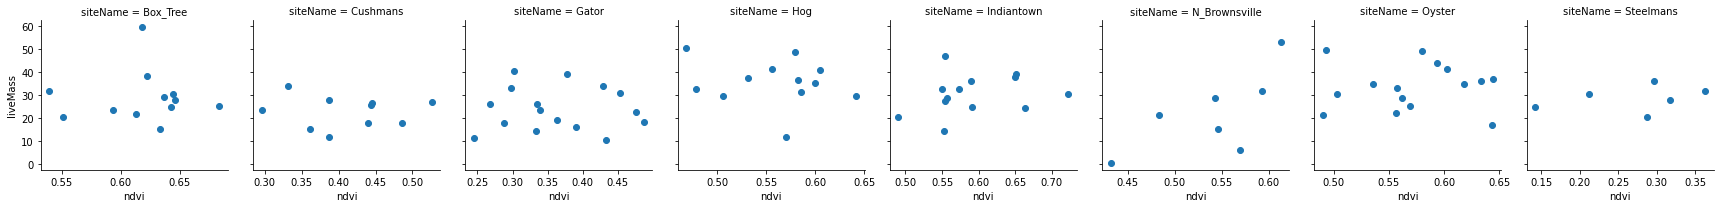

In [15]:
y_y = sns.FacetGrid(df2, col="siteName",  sharex=False) ##the way I'm doing things, ndvi bad predictor!!
g_y = y_y.map(plt.scatter, 'ndvi', 'liveMass')

In [26]:
print("hi")

hi
